# OR 6205 Group 3 Project
## CVRP to find the most economical location for Warehouse

Please Install following packages to run the project

In [28]:
!pip install numpy
!pip install pandas
!pip install pulp
!pip install more-itertools
!pip install math
!pip install scikit-learn
!pip install matplotlib

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools
ERROR: Could not find a version that satisfies the requirement math (from versions: none)
ERROR: No matching distribution found for math


In [2]:
import numpy as np
import pandas as pd
import pulp
import itertools
from math import radians
from sklearn.neighbors import DistanceMetric
import matplotlib.pyplot as plt

### Implementing CVRP to find minimum route distances for all potential warehouse locations 

Import dataframe which contains demand locations co-ordinates.

Ensure that the 'Demands.csv' file is at the same working directory as this notebook

In [3]:
df = pd.read_csv('Demands.csv')
df

,latitude,longitude,demand
0,42.368197,-71.019922,13
1,41.927897,-70.141155,14
2,42.306619,-71.473414,10
3,41.982628,-71.790283,16
4,42.792484,-71.404969,15
5,42.722427,-71.368172,17
6,42.752336,-71.705351,15
7,41.677468,-71.308487,15
8,41.463087,-70.631341,18
9,42.840534,-70.956215,11


In [4]:
# adding 3 potential warehouse locations coordinates
W_1 = pd.DataFrame({'latitude':[42.340335], 'longitude':[-71.131830], 'demand':[0]})
W_2 = pd.DataFrame({'latitude':[42.710020], 'longitude':[-71.740000], 'demand':[0]})
W_3 = pd.DataFrame({'latitude':[41.814841], 'longitude':[-71.508300], 'demand':[0]})

In [5]:
# new dataframe with potential warehouse locations
df1 = pd.concat([W_1, df]).reset_index(drop = True)
df2 = pd.concat([W_2, df]).reset_index(drop = True)
df3 = pd.concat([W_3, df]).reset_index(drop = True)

In [6]:
# function for creating distance matrix for each warehouse locations
def get_dist_matrix(df):

    df['latitude_rad'] = np.radians(df['latitude'])
    df['longitude_rad'] = np.radians(df['longitude'])
    df[['latitude_rad','longitude_rad']].to_numpy()
    dist = DistanceMetric.get_metric('haversine')
    distance = pd.DataFrame(dist.pairwise(df[['latitude_rad','longitude_rad']].to_numpy())*6373,  columns=df.index.unique(), index=df.index.unique())
    return distance

In [7]:
# function for solving LP with pulp
def get_min_dist(distance,vehicle_count,demand_points,vehicle_capacity,df):
    for vehicle_count in range(1,vehicle_count+1):

        # definition of LpProblem
        problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

        # definition of variables which are 0/1(decisiion variables if a route is travelled or not)
        x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(demand_points)] for i in range(demand_points)]

        # add objective function (minimizing travel distances of all the vehicles)
        problem += pulp.lpSum(distance[i][j] * x[i][j][k] if i != j else 0
                              for k in range(vehicle_count) 
                              for j in range(demand_points) 
                              for i in range (demand_points))

        # s.t constraints
        # constraint 1 - only 1 visit to every demand point
        for j in range(1, demand_points):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                                  for i in range(demand_points) 
                                  for k in range(vehicle_count)) == 1 

        # constraint 2 - departing from depot(warehouse node-0)
        for k in range(vehicle_count):
            problem += pulp.lpSum(x[0][j][k] for j in range(1,demand_points)) == 1
            problem += pulp.lpSum(x[i][0][k] for i in range(1,demand_points)) == 1

        # constraint 3 - no of vehicles entering and leaving a demand point is same
        for k in range(vehicle_count):
            for j in range(demand_points):
                problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                                      for i in range(demand_points)) -  pulp.lpSum(x[j][i][k] for i in range(demand_points)) == 0

        # constraint 4 - capacity constraint, delivery capacity must not exceed vehicle capacity
        for k in range(vehicle_count):
            problem += pulp.lpSum(df.demand[j] * x[i][j][k] if i != j else 0 for i in range(demand_points) for j in range (1,demand_points)) <= vehicle_capacity 
       

        # constraint 5 - eliminating subtours()
        subtours = []
        for i in range(2,demand_points):
             subtours += itertools.combinations(range(1,demand_points), i)

        for s in subtours:
            problem += pulp.lpSum(x[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicle_count)) <= len(s) - 1
        
        # print vehicle_count which needed for solving problem
        # print calculated minimum distance value
        if problem.solve() == 1:
            print('Vehicle Requirement:', vehicle_count)
            print('Total route distance kms:', pulp.value(problem.objective))
            plt.figure(figsize=(8,8))
            for i in range(demand_points):    
                if i == 0:
                    plt.scatter(df.latitude[i], df.longitude[i], c='green', s=200)
                    plt.text(df.latitude[i], df.longitude[i], "warehouse", fontsize=12)
                else:
                    plt.scatter(df.latitude[i], df.longitude[i], c='orange', s=200)
                    plt.text(df.latitude[i], df.longitude[i], str(df.demand[i]), fontsize=12)

            for k in range(vehicle_count):
                for i in range(demand_points):
                    for j in range(demand_points):
                        if i != j and pulp.value(x[i][j][k]) == 1:
                            plt.plot([df.latitude[i], df.latitude[j]], [df.longitude[i], df.longitude[j]], c="black")
            plot=plt.show
            return vehicle_count, pulp.value(problem.objective),plot
            break
            

In [29]:
def get_warehouse_optimal_dist(df,vehicle_count,vehicle_capacity,demand_points=11):
    dist_mat = get_dist_matrix(df)
    result = get_min_dist(dist_mat,vehicle_count,demand_points,vehicle_capacity,df)
    return result

#### The following 3 cells should take 3-6 minutes to compute due to the complexity

Total demand points = 11
Vehicle Requirement: 3
Total route distance kms: 688.7710718382834
Wall time: 1min 45s


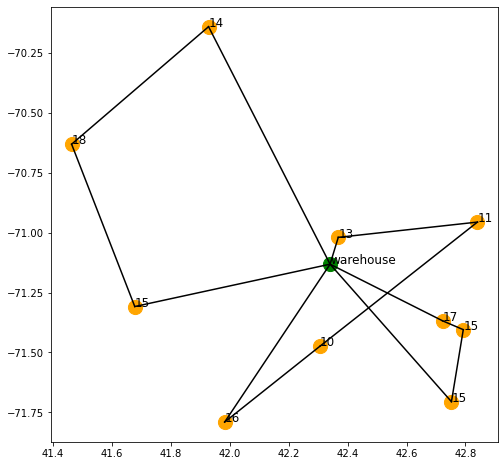

In [9]:
%%time
W1_vehicles,W1_route,W1_plot = get_warehouse_optimal_dist(df1,vehicle_count=4,vehicle_capacity=50)


Total demand points = 11
Vehicle Requirement: 3
Total route distance kms: 755.9301714050924
Wall time: 51.2 s


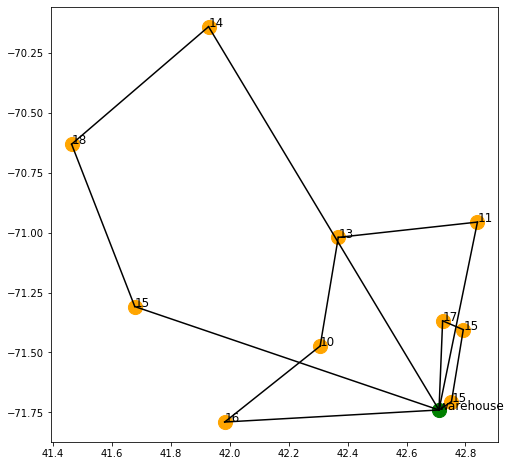

In [10]:
%%time
W2_vehicles,W2_route,W2_plot = get_warehouse_optimal_dist(df2,vehicle_count=4,vehicle_capacity=50)


Total demand points = 11
Vehicle Requirement: 3
Total route distance kms: 777.6152120033222
Wall time: 2min 14s


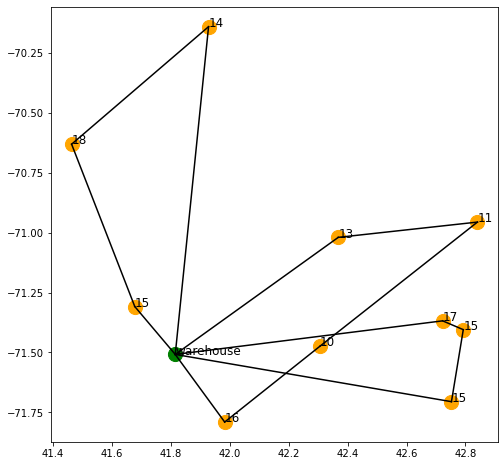

In [11]:
%%time
W3_vehicles,W3_route,W3_plot = get_warehouse_optimal_dist(df3,vehicle_count=4,vehicle_capacity=50)

In [12]:
# appending distances to a list
route_distances = [round(W1_route,ndigits=2),round(W2_route, ndigits=2),round(W3_route, ndigits=2)]
route_distances

[688.77, 755.93, 777.62]

In [13]:
# appending vehicle requirements list
no_of_vehicles = [W1_vehicles,W2_vehicles,W3_vehicles]
no_of_vehicles

[3, 3, 3]

### Final Decision LP

Here we are using the distance obtained from CVRP to find the minimum cost for establishing a warehouse at a given location.

We determine the most economical warehouse based on financials constraints where we calculate the sum of Fixed and Variable costs for each warehouse.

In [38]:
# Setting the fixed and variable costs parameters for each warehouse
warehouse_fixed_costs = [150000, 180000, 120000]
cost_per_km = [2,2,2]
cost_of_vehicle = [2000, 2000, 2000]
warehouses = ['1','2','3']

In [39]:
# Calculating the variable costs required for LP 
transport_costs = [cost_per_km[i]*route_distances[i] for i in range(len(cost_per_km))]
vehicle_costs = [no_of_vehicles[i]*cost_of_vehicle[i] for i in range(len(no_of_vehicles))]
variable_costs = [transport_costs[i]+vehicle_costs[i] for i in range(len(transport_costs))]

##### Creating LP problem (Cost Minimization) for second step 

In [40]:
model = pulp.LpProblem("Warehouse_Decision_and_Cost", pulp.LpMinimize)

In [41]:
# Creating Binary decision Variables for the warehouse & vehicles
warehouse_dv = pulp.LpVariable.matrix("X", warehouses, cat = "Binary", lowBound = 0)
warehouse_dv_values = np.array(warehouse_dv)

vehicle_dv = pulp.LpVariable.matrix("Y", warehouses, cat = "Binary", lowBound = 0)
vehicle_dv_values = np.array(vehicle_dv)

In [42]:
# Defining Objective Function
obj_func = pulp.lpSum(variable_costs*vehicle_dv_values)
obj_func += pulp.lpSum(warehouse_fixed_costs*warehouse_dv_values)
model += obj_func
model

Warehouse_Decision_and_Cost:
MINIMIZE
150000*X_1 + 180000*X_2 + 120000*X_3 + 7377.54*Y_1 + 7511.86*Y_2 + 7555.24*Y_3 + 0.0
VARIABLES
0 <= X_1 <= 1 Integer
0 <= X_2 <= 1 Integer
0 <= X_3 <= 1 Integer
0 <= Y_1 <= 1 Integer
0 <= Y_2 <= 1 Integer
0 <= Y_3 <= 1 Integer

In [43]:
# Adding constraint if warehouse is built then vehicle must be procured
for i in range(0,3):
    const = pulp.lpSum(warehouse_dv_values[i]) == pulp.lpSum(vehicle_dv_values[i]), "Delivery Vehicles Purchased for Warehouse" + str(i)
    model += const

In [44]:
# Adding constraint for only one warehouse selection
const2 = pulp.lpSum(warehouse_dv_values) == 1, "Only one warehouse is made"
model += const2

In [47]:
# Adding Constraint for operations budget wrt capital
for i in range(len(vehicle_dv_values)):
    budget_vehicle_const = pulp.lpSum(vehicle_dv_values[i]*variable_costs[i])<= 0.10*warehouse_fixed_costs[i], "Operations budget wrt capital" + str(i+1)
    model += budget_vehicle_const

In [48]:
model

Warehouse_Decision_and_Cost:
MINIMIZE
150000*X_1 + 180000*X_2 + 120000*X_3 + 7377.54*Y_1 + 7511.86*Y_2 + 7555.24*Y_3 + 0.0
SUBJECT TO
Delivery_Vehicles_Purchased_for_Warehouse0: X_1 - Y_1 = 0

Delivery_Vehicles_Purchased_for_Warehouse1: X_2 - Y_2 = 0

Delivery_Vehicles_Purchased_for_Warehouse2: X_3 - Y_3 = 0

Only_one_warehouse_is_made: X_1 + X_2 + X_3 = 1

Vehicle_budget_1: 7377.54 Y_1 <= 15000

Vehicle_budget_2: 7511.86 Y_2 <= 18000

Vehicle_budget_3: 7555.24 Y_3 <= 12000

Operations_budget_wrt_capital1: 7377.54 Y_1 <= 15000

Operations_budget_wrt_capital2: 7511.86 Y_2 <= 18000

Operations_budget_wrt_capital3: 7555.24 Y_3 <= 12000

VARIABLES
0 <= X_1 <= 1 Integer
0 <= X_2 <= 1 Integer
0 <= X_3 <= 1 Integer
0 <= Y_1 <= 1 Integer
0 <= Y_2 <= 1 Integer
0 <= Y_3 <= 1 Integer

In [49]:
# Selecting Solver and solving the model
solver = pulp.PULP_CBC_CMD() 
model.solve(solver)

1

In [50]:
status = pulp.LpStatus[model.status]
status

'Optimal'

In [51]:
model.objective.value()

127555.24

In [52]:
# Objective Func and DV values
print("Total Cost:", model.objective.value())
# Decision Variables

for v in model.variables():
    try:
        print(v.name,"=", v.value())
    except:
        print("error couldnt find value")

Total Cost: 127555.24
X_1 = 0.0
X_2 = 0.0
X_3 = 1.0
Y_1 = 0.0
Y_2 = 0.0
Y_3 = 1.0
